### Debiasing CPM with CEBaB
Our Causal Proxy Model (CPM) has localized information about different concepts. The overall debiasing effort in CPM is letting the model to predict the output as if the concept that gets to be debiased is not presented in the text (i.e., the concept label is ``unknown``).

In this document, we show that CPM can be integrated as a method to produce debiased model with respect to targeted concept. This document is just one example of how we can use CPM to produce debiased outputs. In the paper, we also discuss how the iCACE score relates to this debiased results.

In this notebook, we will evaluate the following models:
- CPM: `BERT-base-uncased`

and we will evaluate with the following conditions:
- 5-class

#### Imports and Libs

In [1]:
from libs import *
from modelings.modelings_bert import *
from modelings.modelings_roberta import *
from modelings.modelings_gpt2 import *
from modelings.modelings_lstm import *

"""
For evaluate, we use a single random seed, as
the models are trained with 5 different seeds
already.
"""
_ = random.seed(123)
_ = np.random.seed(123)
_ = torch.manual_seed(123)

In [4]:
"""
The following blocks will run CEBaB benchmark in
all the combinations of the following conditions.
"""
grid = {
    "eval_split": ["test"],
    # dev,test
    "control": ["ks"],
    # baseline-random,baseline-blackbox,hdims,layers,ks,approximate,ablation
    "seed": [42],
    # 42, 66, 77
    "h_dim": [192],
    # 1,16,64,128,192
    # 1,16,64,75
    "interchange_layer" : [10],
    # 0,1; 2,4,6,8,10,12
    "class_num": [5],
    "k" : [19684], 
    # 0;10,100,500,1000,3000,6000,9848,19684
    "alpha" : [1.0],
    # 0.0,1.0
    "beta" : [1.0],
    # 0.0,1.0
    "gemma" : [3.0],
    # 0.0,3.0
    "model_arch" : ["bert-base-uncased"],
    # lstm, bert-base-uncased, roberta-base, gpt2
    "lr" : ["8e-05"],
    # 8e-05; 0.001
    "counterfactual_type" : ["true"]
    # approximate,true
}

keys, values = zip(*grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

device = 'cuda:9'
batch_size = 32

if grid["control"][0] == "hdims" or grid["control"][0] == "layers":
    assert grid["eval_split"][0] == "dev"
else:
    assert grid["eval_split"][0] == "test"
    
aspect_label_encode = {
    "Negative":0,
    "Positive":1,
    "unknown":2,
    "no majority": 2,
}

In [5]:
i = 0
eval_split=permutations_dicts[i]["eval_split"]
seed=permutations_dicts[i]["seed"]
class_num=permutations_dicts[i]["class_num"]
alpha=permutations_dicts[i]["alpha"]
beta=permutations_dicts[i]["beta"]
gemma=permutations_dicts[i]["gemma"]
h_dim=permutations_dicts[i]["h_dim"]
dataset_type = f'{class_num}-way'
control=permutations_dicts[i]["control"]
model_arch=permutations_dicts[i]["model_arch"]
k=permutations_dicts[i]["k"]
interchange_layer=permutations_dicts[i]["interchange_layer"]
lr=permutations_dicts[i]["lr"]
counterfactual_type=permutations_dicts[i]["counterfactual_type"]

if model_arch == "bert-base-uncased":
    model_path = "BERT"
    model_module = BERTForCEBaB
    explainer_module = CausalProxyModelForBERT
elif model_arch == "roberta-base":
    model_path = "RoBERTa" 
    model_module = RoBERTaForCEBaB
    explainer_module = CausalProxyModelForRoBERTa
elif model_arch == "gpt2":
    model_path = "gpt2"
    model_module = GPT2ForCEBaB
    explainer_module = CausalProxyModelForGPT2
elif model_arch == "lstm":
    model_path = "lstm"
    model_module = LSTMForCEBaB
    explainer_module = CausalProxyModelForLSTM
model_path += f"-{control}"
grid_conditions=(
    ("eval_split", eval_split),
    ("control", control),
    ("seed", seed),
    ("h_dim", h_dim),
    ("interchange_layer", interchange_layer),
    ("class_num", class_num),
    ("k", k),
    ("alpha", alpha),
    ("beta", beta),
    ("gemma", gemma),
    ("model_arch", model_arch),
    ("lr", lr),
    ("counterfactual_type", counterfactual_type)
)
print("Running for this setting: ", grid_conditions)

blackbox_model_path = f'CEBaB/{model_arch}.CEBaB.sa.'\
                      f'{class_num}-class.exclusive.seed_{seed}'
cpm_model_path = f'../proxy_training_results/{model_path}/'\
                 f'cebab.alpha.{alpha}.beta.{beta}.gemma.{gemma}.'\
                 f'lr.{lr}.dim.{h_dim}.hightype.{model_arch}.'\
                 f'CEBaB.cls.dropout.0.1.enc.dropout.0.1.counter.type.'\
                 f'{counterfactual_type}.k.{k}.int.layer.{interchange_layer}.'\
                 f'seed_{seed}/'

# load data from HF
cebab = datasets.load_dataset(
    'CEBaB/CEBaB', use_auth_token=True,
    cache_dir="../train_cache/"
)

train, dev, test = preprocess_hf_dataset_inclusive(
    cebab, verbose=1, dataset_type=dataset_type
)

eval_dataset = dev if eval_split == 'dev' else test

tf_model = model_module(
    blackbox_model_path, 
    device=device, 
    batch_size=batch_size
)
explainer = explainer_module(
    blackbox_model_path,
    cpm_model_path, 
    device=device, 
    batch_size=batch_size,
    intervention_h_dim=h_dim,
)

Running for this setting:  (('eval_split', 'test'), ('control', 'ks'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


In [58]:
decorrelate_concept = "food" # TODO: integrate this, make it as a function!

correlate_results = []
decorrelate_results = []

train_df = train[0]
for index, row in eval_dataset.iterrows():
    ambiance = row['ambiance_aspect_majority']
    food = row['food_aspect_majority']
    noise = row['noise_aspect_majority']
    service = row['service_aspect_majority']
    description = row['description']

    # Original ratings.
    x = explainer.tokenizer([description], padding=True, truncation=True, return_tensors='pt')
    x_batch = {k: v.to(explainer.device) for k, v in x.items()}
    outputs = explainer.blackbox_model(
        **x_batch,
    )
    output_logit = torch.nn.functional.softmax(
        outputs.logits.cpu(), dim=-1
    ).detach()[0]
    vp_class_prob = output_logit[-1].tolist()
    correlate_results += [(ambiance, food, noise, service, vp_class_prob)]
    
    # sample a trainign as the counterfactual outputs!
    satisfied_rows = train_df[
        (train_df[f"{decorrelate_concept}_aspect_majority"]==\
         "unknown")
    ]
    sampled_source = satisfied_rows.sample(random_state=seed).iloc[0]
    source_description = sampled_source['description']
    source_x = explainer.tokenizer([source_description], padding=True, truncation=True, return_tensors='pt')
    source_x_batch = {k: v.to(explainer.device) for k, v in source_x.items()}
    
    if decorrelate_concept == "ambiance":
        intervention_type_batch = torch.tensor([0]).long().to(explainer.device)
    if decorrelate_concept == "food":
        intervention_type_batch = torch.tensor([1]).long().to(explainer.device)
    if decorrelate_concept == "noise":
        intervention_type_batch = torch.tensor([2]).long().to(explainer.device)
    if decorrelate_concept == "service":
        intervention_type_batch = torch.tensor([3]).long().to(explainer.device)
    
    base_input_ids = x_batch['input_ids']
    base_attention_mask = x_batch['attention_mask']
    source_input_ids = source_x_batch['input_ids']
    source_attention_mask = source_x_batch['attention_mask']
    
    # Decorrelate ratings.
    _, _, counterfactual_outputs = explainer.cpm_model.forward(
        base=(base_input_ids, base_attention_mask),
        source=(source_input_ids, source_attention_mask),
        base_intervention_corr=intervention_type_batch,
        source_intervention_corr=intervention_type_batch,
    )
    prediction_counterfactual_batch = torch.nn.functional.softmax(
        counterfactual_outputs["logits"][0].cpu(), dim=-1
    ).detach()[0]

    intervened_vp_class_prob = prediction_counterfactual_batch[-1].tolist()
    decorrelate_results += [(ambiance, food, noise, service, intervened_vp_class_prob)]

/dfs/user/wuzhengx/tool-chain/anaconda3/lib/python3.7/site-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [60]:
def group_logits(
    correlate_results,
    concept_idx,
):
    group_results = {
        "Negative" : [],
        "unknown" : [],
        "Positive" : [],
    }
    for i in range(len(correlate_results)):
        if correlate_results[i][concept_idx] != "":
            logit = correlate_results[i][-1]
            group_results[correlate_results[i][concept_idx]].append(logit)
    return group_results

def subplot_func(ax, index, results, with_labels=False, with_title=False):
    group_result = group_logits(results, index)
    names = ["ambiance", "food", "noise", "service"]
    ax.boxplot(
        np.asarray([
            group_result["Negative"],
            group_result["unknown"],
            group_result["Positive"],
        ], dtype=object), 
        labels=["neg", "unk", "pos"]
    )
    line_x = []
    linx_y = []
    for l in group_result["Negative"]:
        line_x.append(1)
        linx_y.append(l)
    for l in group_result["unknown"]:
        line_x.append(2)
        linx_y.append(l)
    for l in group_result["Positive"]:
        line_x.append(3)
        linx_y.append(l)
    corr, _ = pearsonr(line_x, linx_y)
    corr = round(corr, 2)
    ax.plot(
        np.unique(line_x), np.poly1d(
            np.polyfit(line_x, linx_y, 1)
        )(np.unique(line_x)),
        linestyle='dashdot',
        color='red',
        alpha=0.8,
        linewidth=2,
        label=f"corr={corr}"
    )
    ax.legend(
        loc="upper right",
        ncol=1, fancybox=True, fontsize=15,
        framealpha=0.2
    )
    if with_title:
        ax.set_title(names[index], fontsize=20)
    if not with_labels:
        ax.get_xaxis().set_ticks([])
    else:
        ax.xaxis.set_tick_params(labelsize=20)

    ax.set_facecolor("white")

    return ax

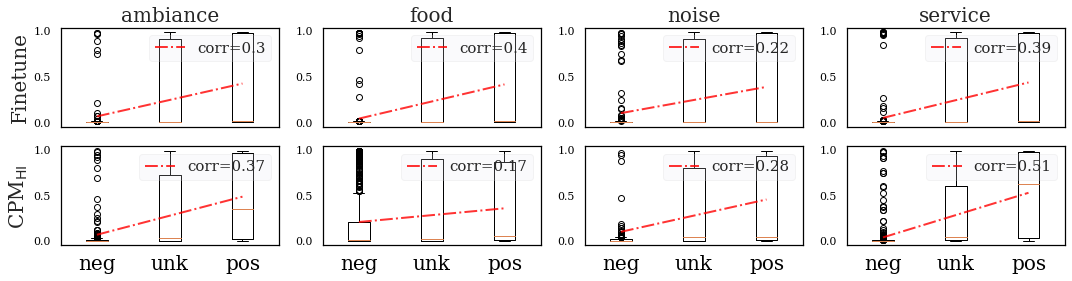

In [62]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig, axs = plt.subplots(2, 4, figsize=(18, 4))
    # Blackbox model
    for i in range(0, 4):
        subplot_func(axs[0,i], i, correlate_results, with_title=True)
        axs[0,0].set_ylabel("Finetune", fontsize=20)
        
    # CPM
    for i in range(0, 4):
        subplot_func(axs[1,i], i, decorrelate_results, with_labels=True)
        axs[1,0].set_ylabel(r'CPM$_{\rm HI}$', fontsize=20)
    plt.savefig("./figures/debiasing.png",dpi=200, bbox_inches='tight')
        